# TSFresh exploration

In [2]:
from tsfresh import select_features, extract_relevant_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from get_processed_data import get_processed_data, get_train_test_split
import pandas as pd

In [3]:
train, test  = get_train_test_split(
  'malte', 60 * 15, 60 * 3
)

print("train hard", len(train["hard"]))
print("train easy", len(train["easy"]))

print("test hard", len(test["hard"]))
print("test easy", len(test["easy"]))


train hard 27
train easy 18
test hard 6
test easy 1


## Prepare data for TSFresh
Convert data to a single pandas dataframe and generate a unique id for each climb.

Also, generate a labels array, that indicates 0 for an easy route and 1 for a hard route for each climb.

In [4]:
easy_routes = get_processed_data("malte", ["3", "4"], 60 * 15, 60 * 3)
hard_routes = get_processed_data("malte", ["6", "6+"], 60 * 15, 60 * 3)

all_climbs = []
labels = pd.Series() # 0 = not hard, 1 = hard
i = 0


for route in easy_routes:
    data  = pd.DataFrame(route)
    data = data.drop("PacketCounter", axis=1)
    data["id"] = i
    all_climbs.append(data)
    labels[i] = False
    i += 1

for route in hard_routes:
    data  = pd.DataFrame(route)
    data = data.drop("PacketCounter", axis=1)
    data["id"] = i
    all_climbs.append(data)
    labels[i] = True
    i += 1

all_climbs_df = pd.concat(all_climbs)

In [19]:
# now we can extract features from all_climbs
extracted_features = extract_features(all_climbs_df, column_id="id", column_sort="SampleTimeFine", column_kind=None, column_value=None)
extracted_features.to_csv("extracted_features.csv")

Feature Extraction: 100%|██████████| 20/20 [08:29<00:00, 25.47s/it]


In [5]:
extracted_features = pd.read_csv("extracted_features.csv", index_col=0)


In [6]:
# drop columns with NaN values
extracted_features_without_nan = impute(extracted_features)

# # now we can filter out the relevant features
filtered_features = select_features(extracted_features_without_nan, labels)
# filtered_features

/Users/malte/Developer/data-science-for-wearables/.venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Quat_W__query_similarity_count__query_None__threshold_0.0'
 'Quat_X__query_similarity_count__query_None__threshold_0.0'
 'Quat_Y__query_similarity_count__query_None__threshold_0.0'
 'Quat_Z__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_X__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_Y__query_similarity_count__query_None__threshold_0.0'
 'FreeAcc_Z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


class PCAForPandas(PCA):
    """This class is just a small wrapper around the PCA estimator of sklearn including normalization to make it 
    compatible with pandas DataFrames.
    """

    def __init__(self, **kwargs):
        self._z_scaler = StandardScaler()
        super(self.__class__, self).__init__(**kwargs)

        self._X_columns = None

    def fit(self, X, y=None):
        """Normalize X and call the fit method of the base class with numpy arrays instead of pandas data frames."""

        X = self._prepare(X)

        self._z_scaler.fit(X.values, y)
        z_data = self._z_scaler.transform(X.values, y)

        return super(self.__class__, self).fit(z_data, y)

    def fit_transform(self, X, y=None):
        """Call the fit and the transform method of this class."""

        X = self._prepare(X)

        self.fit(X, y)
        return self.transform(X, y)

    def transform(self, X, y=None):
        """Normalize X and call the transform method of the base class with numpy arrays instead of pandas data frames."""

        X = self._prepare(X)

        z_data = self._z_scaler.transform(X.values, y)

        transformed_ndarray = super(self.__class__, self).transform(z_data)

        pandas_df = pd.DataFrame(transformed_ndarray)
        pandas_df.columns = ["pca_{}".format(i) for i in range(len(pandas_df.columns))]

        return pandas_df

    def _prepare(self, X):
        """Check if the data is a pandas DataFrame and sorts the column names.

        :raise AttributeError: if pandas is not a DataFrame or the columns of the new X is not compatible with the 
                               columns from the previous X data
        """
        if not isinstance(X, pd.DataFrame):
            raise AttributeError("X is not a pandas DataFrame")

        X.sort_index(axis=1, inplace=True)

        if self._X_columns is not None:
            if self._X_columns != list(X.columns):
                raise AttributeError("The columns of the new X is not compatible with the columns from the previous X data")
        else:
            self._X_columns = list(X.columns)

        return X

In [8]:
pca_train_3d = PCAForPandas(n_components=3)
X_train_pca_3d = pca_train_3d.fit_transform(filtered_features)

pca_train_2d = PCAForPandas(n_components=2)
X_train_pca_2d = pca_train_2d.fit_transform(filtered_features)

In [9]:
X_train_pca_2d.to_csv("pca_2d.csv")

labels.to_csv("labels.csv")

# add a column with difficulty to the pca data 
# if False then "easy", if True then "hard"
X_train_pca_2d["difficulty"] = labels.map({False: "easy", True: "hard"})
X_train_pca_2d.to_csv("pca_2d.csv")



In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

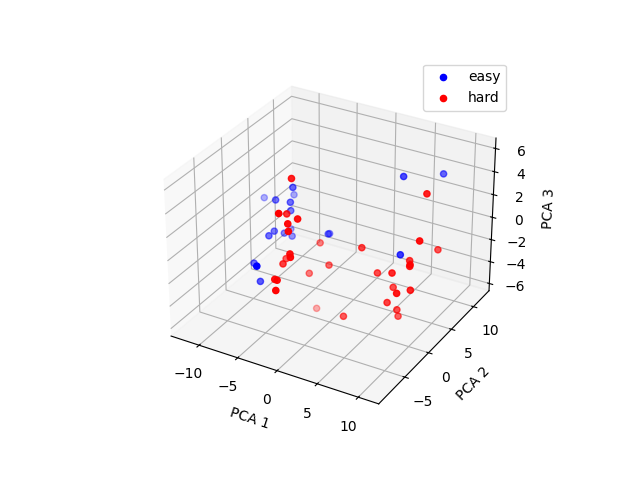

In [14]:
# plot X_train_pca  as 3d scatter plot


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_pca_3d[labels == 0].iloc[:, 0], X_train_pca_3d[labels == 0].iloc[:, 1], X_train_pca_3d[labels == 0].iloc[:, 2], c='b', label="easy")
ax.scatter(X_train_pca_3d[labels == 1].iloc[:, 0], X_train_pca_3d[labels == 1].iloc[:, 1], X_train_pca_3d[labels == 1].iloc[:, 2], c='r', label="hard")

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()

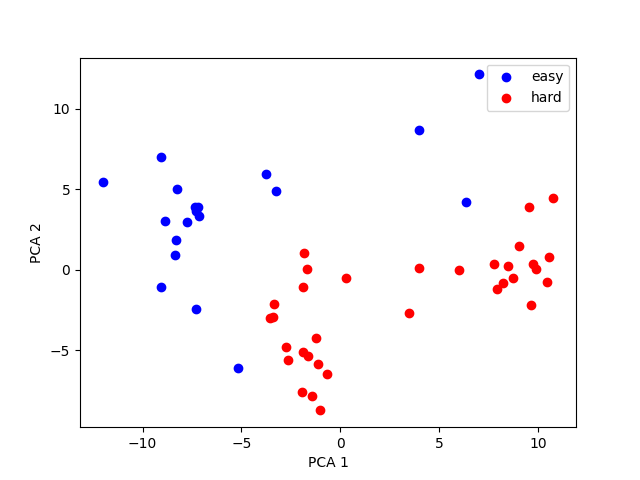

In [13]:
# plot X_train_pca  as 2d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X_train_pca_2d[labels == 0].iloc[:, 0], X_train_pca_2d[labels == 0].iloc[:, 1], c='b', label="easy")
ax.scatter(X_train_pca_2d[labels == 1].iloc[:, 0], X_train_pca_2d[labels == 1].iloc[:, 1], c='r', label="hard")

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.legend()

plt.show()